In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np

set_seed(1234)

2023-08-02 22:48:03.467241: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-02 22:48:03.498077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 22:48:03.929752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [3]:
dataset_name = DatasetName.RADIOML_2016
radioml2016b_path = cur_dir + "/data/radioml_2016/RML2016.10b.dat"
radioml2016a_path = cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl"
dataset_path = os.path.abspath(radioml2016b_path)
radioml_ds = make_sigmod_ds(dataset_name)
radioml_ds.load(dataset_path)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)

# Create Model
Create convolutional model

In [4]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName

# cnn_1d_v012_1_configuration = Convolution01xConfiguration(
#     input_shape=(128, 2),
#     n_classes=len(radioml_ds.get_modulations()),
#     output_channels=[32, 48, 64, 96, 128, 192],
#     kernel_sizes=[8, 8, 8, 8, 8, 8],
#     paddings=["same", "same", "same", "same", "same", "same"],
#     max_pool_sizes=[1, 1, 2, 1, 2, 1],
#     max_pool_strides=[1, 1, 2, 1, 2, 1],
#     avg_size=32,
#     dense_sizes=[],
# )

# cnn_1d_v012_2_configuration = Convolution01xConfiguration(
#     input_shape=(128, 2),
#     n_classes=len(radioml_ds.get_modulations()),
#     output_channels=[32, 48, 64, 96],
#     kernel_sizes=[8, 8, 8, 8],
#     paddings=["same", "same", "same", "same",],
#     max_pool_sizes=[1, 2, 2, 1],
#     max_pool_strides=[1, 2, 2, 1],
#     avg_size=32,
#     dense_sizes=[96],
# )
model_name = "cnn_1d_v012_small_radio_ml18"

cnn_1d_v012_3_configuration = Convolution01xConfiguration(
    input_shape=(128, 2),
    n_classes=len(radioml_ds.get_modulations()),
    output_channels=[32, 48, 64, 96],
    kernel_sizes=[8, 8, 8, 8],
    paddings=["same", "same", "same", "same",],
    max_pool_sizes=[1, 2, 2, 1],
    max_pool_strides=[1, 2, 2, 1],
    avg_size=32,
    dense_sizes=[96],
)

model_configuration = cnn_1d_v012_3_configuration

model = make_sigmod_model(ModelName.CNN_1D_V012, model_configuration)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 CNN0_ (Conv1D)              (None, 128, 32)           544       
                                                                 
 MAX_POOL_0_ (MaxPooling1D)  (None, 128, 32)           0         
                                                                 
 BN0_ (CustomBatchNorm)      (None, 128, 32)           128       
                                                                 
 CNN_REL0_ (ReLU)            (None, 128, 32)           0         
                                                                 
 CNN1_ (Conv1D)              (None, 128, 48)           12336     
                                                                 
 MAX_POOL_1_ (MaxPooling1D)  (None, 64, 48)            0     

2023-08-01 22:49:54.247855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-01 22:49:54.339075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-01 22:49:54.339400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [5]:
import tensorflow as tf

def step_decay(epoch):
    # lrate = 0.001
    # factor = epoch // 8
    # lrate /= 10**factor
    return 0.001
    lrate = 0.001
    if epoch >= 16:
        lrate /= 10
    if epoch >= 24:
        lrate /= 4
    if epoch >= 32:
        lrate /= 4
    if epoch >= 40:
        lrate /= 2
    # factor = epoch // 8
    # lrate /= 10**factor
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# N_EPOCHS = 16
N_EPOCHS = 48
BATCH_SIZE = 256

h = model.fit(
    splitted_radioml_ds.train.data,
    splitted_radioml_ds.train.labels,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
    callbacks=[lrate]
)


Epoch 1/48


2023-08-01 22:50:02.225389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-01 22:50:03.242126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-01 22:50:03.256022: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fc1d1a8f220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-01 22:50:03.256039: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-08-01 22:50:03.272445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-01 22:50:03.446001: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

3750/3750 [==============================] - 24s 5ms/step - loss: 1.3761 - accuracy: 0.4398 - val_loss: 1.1180 - val_accuracy: 0.5281 - lr: 0.0010
Epoch 2/48
3750/3750 [==============================] - 19s 5ms/step - loss: 1.0856 - accuracy: 0.5415 - val_loss: 1.0563 - val_accuracy: 0.5534 - lr: 0.0010
Epoch 3/48
3750/3750 [==============================] - 19s 5ms/step - loss: 1.0415 - accuracy: 0.5603 - val_loss: 1.0205 - val_accuracy: 0.5715 - lr: 0.0010
Epoch 4/48
3750/3750 [==============================] - 19s 5ms/step - loss: 1.0123 - accuracy: 0.5727 - val_loss: 1.0018 - val_accuracy: 0.5754 - lr: 0.0010
Epoch 5/48
3750/3750 [==============================] - 19s 5ms/step - loss: 0.9990 - accuracy: 0.5781 - val_loss: 1.0096 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 6/48
3750/3750 [==============================] - 19s 5ms/step - loss: 0.9910 - accuracy: 0.5813 - val_loss: 0.9901 - val_accuracy: 0.5823 - lr: 0.0010
Epoch 7/48
3750/3750 [==============================] - 19s 5ms

# Evaluation
Check train plots, confusion matrices, snr to accuracy

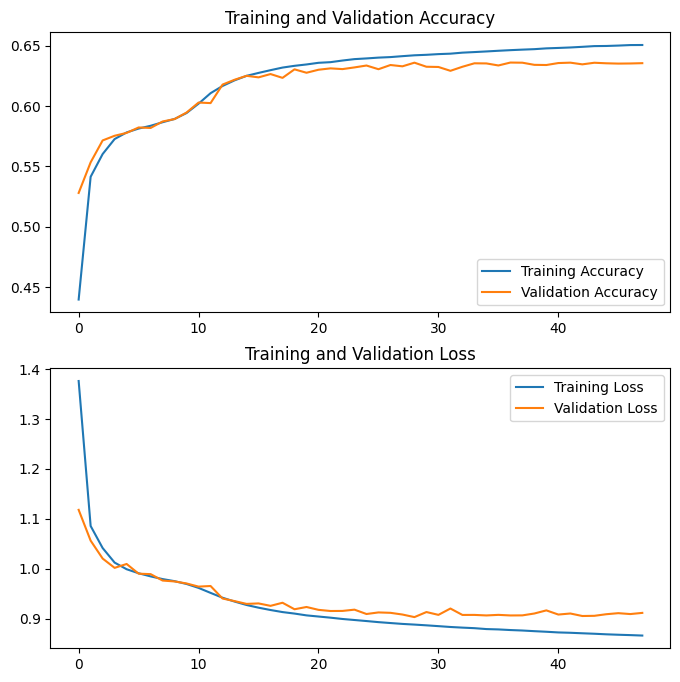

In [6]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
plot_train(h.history)

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6346833333333334}
8PSK test accuracy: 0.7056728778467909
AM-DSB test accuracy: 0.7398206794439418
BPSK test accuracy: 0.6249583472175941
CPFSK test accuracy: 0.6797980633948523
GFSK test accuracy: 0.7136465324384788
PAM4 test accuracy: 0.7113307093208274
QAM16 test accuracy: 0.6047410894418291
QAM64 test accuracy: 0.671595912602808
QPSK test accuracy: 0.6007854520618117
WBFM test accuracy: 0.2918087318087318
Confusion matrix:
[[8521  304  244  659  527  117  341  340  820  202]
 [1163 8994  121  256  387   39   29   11  287  870]
 [1843  297 7502  509  498  471   96   66  520  202]
 [1767  317  190 8214  612   83  121   87  493  199]
 [1496  455  136  486 8613   58   53   27  396  349]
 [1297  214  469  374  384 8494   85   72  423  129]
 [1420  171  192  500  351   84 7194 1305  547  132]
 [ 931  114  139  358  240  122 1547 8084  422   80]
 [2181  310  208  665  511  114  278  220 7037  189]
 [1192 5918  112  269  623   4

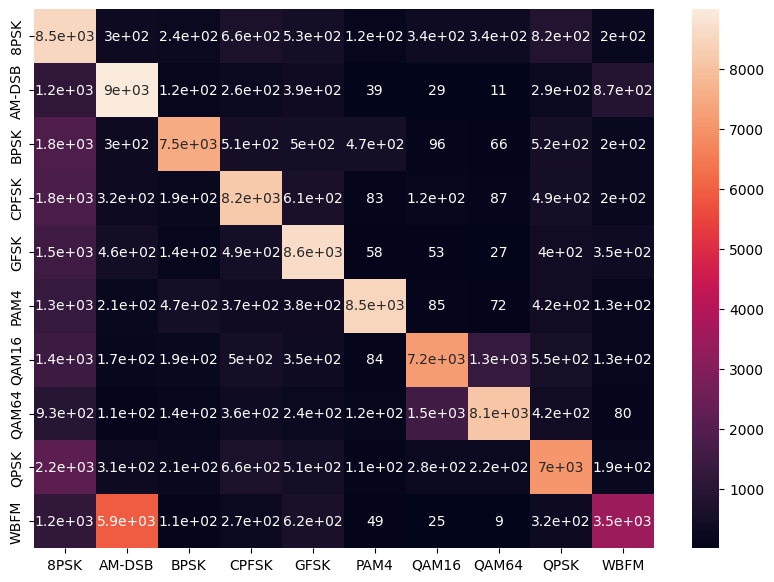

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6354416666666667}
8PSK test accuracy: 0.6982479448642365
AM-DSB test accuracy: 0.735123005319149
BPSK test accuracy: 0.6255079193963016
CPFSK test accuracy: 0.6839520559347428
GFSK test accuracy: 0.7149275239467662
PAM4 test accuracy: 0.7128524046434495
QAM16 test accuracy: 0.6218154209549519
QAM64 test accuracy: 0.6763526233936318
QPSK test accuracy: 0.5894359743397484
WBFM test accuracy: 0.2935156446606828
Confusion matrix:
[[8409  299  260  615  559  130  342  338  873  218]
 [1171 8845  106  247  375   51   26    6  307  898]
 [1825  300 7543  522  448  495   84   72  567  203]
 [1666  295  185 8217  646   91  115   77  521  201]
 [1423  434  123  499 8434   55   59   21  391  358]
 [1293  249  476  378  343 8597   84  107  401  132]
 [1437  154  156  469  312  124 7371 1206  501  124]
 [ 932  119  133  364  245   98 1550 8263  428   85]
 [2246  321  215  707  548  117  262  293 7075  219]
 [1177 5881  112  271  611   4

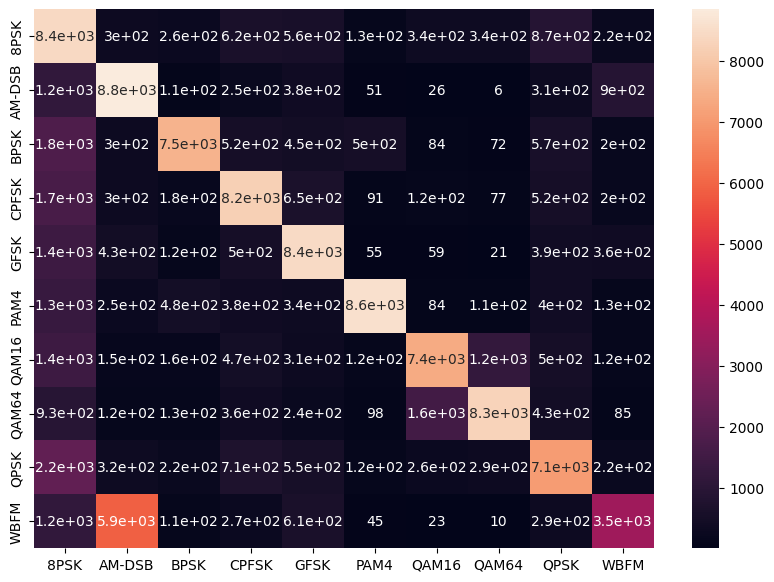

In [7]:
cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.10150189800297078
SNR: -18 -- Overall test accuracy: 0.10920877659574468
SNR: -16 -- Overall test accuracy: 0.11893977520550243
SNR: -14 -- Overall test accuracy: 0.16610794502179013
SNR: -12 -- Overall test accuracy: 0.2096533421794659
SNR: -10 -- Overall test accuracy: 0.2940881763527054
SNR: -8 -- Overall test accuracy: 0.404
SNR: -6 -- Overall test accuracy: 0.5541044776119403
SNR: -4 -- Overall test accuracy: 0.7162319322146536
SNR: -2 -- Overall test accuracy: 0.8158808933002482
SNR: 0 -- Overall test accuracy: 0.885199867855963
SNR: 2 -- Overall test accuracy: 0.9158722194346881
SNR: 4 -- Overall test accuracy: 0.9254914918222369
SNR: 6 -- Overall test accuracy: 0.9283431455004205
SNR: 8 -- Overall test accuracy: 0.926146713031959
SNR: 10 -- Overall test accuracy: 0.9204507789194564
SNR: 12 -- Overall test accuracy: 0.9259574468085107
SNR: 14 -- Overall test accuracy: 0.9265489673550966
SNR: 16 -- Overall test accuracy: 0.9242601571643538
SNR

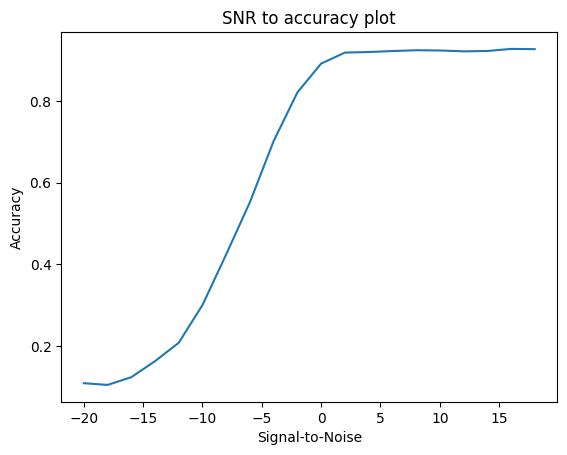

In [8]:
snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_val)

# Save results

In [13]:
# reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))

dump_results(
    model_name + "_results/",
    model=model,
    model_config=model_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    short_description="Smaller + dense, 48 epochs with more decay (16:/=10, 24:/=4, 32: /=4)",
    dump_model=True,
)

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml_results/model_original/assets
2023-07-31 20:54:46.853826: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-31 20:54:46.853855: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-31 20:54:46.854178: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml_results/model_original
2023-07-31 20:54:46.856699: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-31 20:54:46.856715: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml_results/model_original
2023-07-31 20:54:46.862598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-31 20:54:46.865096: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel b

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.576590909090909}
8PSK test accuracy: 0.5602284527518172
AM-DSB test accuracy: 0.6800995024875622
AM-SSB test accuracy: 0.922740524781341
BPSK test accuracy: 0.6316042267050913
CPFSK test accuracy: 0.6130367304707708
GFSK test accuracy: 0.6587419514611194
PAM4 test accuracy: 0.6874051593323217
QAM16 test accuracy: 0.1892161757363954
QAM64 test accuracy: 0.6251881585549423
QPSK test accuracy: 0.5074320861096874
WBFM test accuracy: 0.26171875
Confusion matrix:
[[1079   15  586   54   22   31   21   16   55   43    4]
 [   3 1367  488   13    2   26    3    1    1    1  105]
 [   6   21 1899   50   12   38   13    3    4    4    8]
 [  16    5  629 1315    4   21   67    3    9   12    1]
 [  39   11  568   35 1185   46    8   10    9   16    6]
 [   6   24  541   28    8 1330    5    1    6    9   61]
 [   8   10  470   85    5   25 1359    2    7    4    2]
 [  98    9  374   56   22   19   15  379  983   48    0]
 [  75    7 

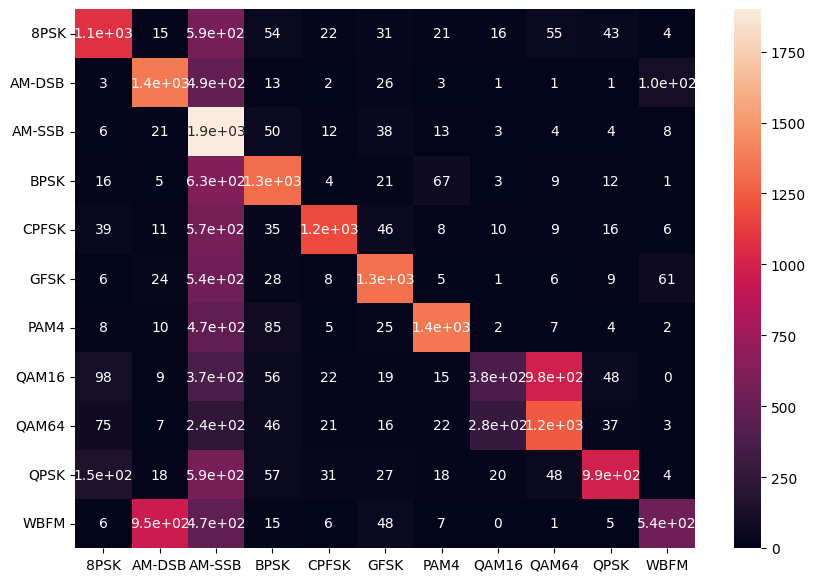

SNR: -20 -- Overall test accuracy: 0.10711150131694469
SNR: -18 -- Overall test accuracy: 0.09408602150537634
SNR: -16 -- Overall test accuracy: 0.09905660377358491
SNR: -14 -- Overall test accuracy: 0.10950226244343891
SNR: -12 -- Overall test accuracy: 0.15944700460829492
SNR: -10 -- Overall test accuracy: 0.24192059095106186
SNR: -8 -- Overall test accuracy: 0.4040492957746479
SNR: -6 -- Overall test accuracy: 0.5413184772516249
SNR: -4 -- Overall test accuracy: 0.6509769094138543
SNR: -2 -- Overall test accuracy: 0.7640845070422535
SNR: 0 -- Overall test accuracy: 0.796875
SNR: 2 -- Overall test accuracy: 0.8394160583941606
SNR: 4 -- Overall test accuracy: 0.8427906976744186
SNR: 6 -- Overall test accuracy: 0.8441674087266251
SNR: 8 -- Overall test accuracy: 0.8380603842634949
SNR: 10 -- Overall test accuracy: 0.8406593406593407
SNR: 12 -- Overall test accuracy: 0.855072463768116
SNR: 14 -- Overall test accuracy: 0.8438331854480923
SNR: 16 -- Overall test accuracy: 0.83065279091769

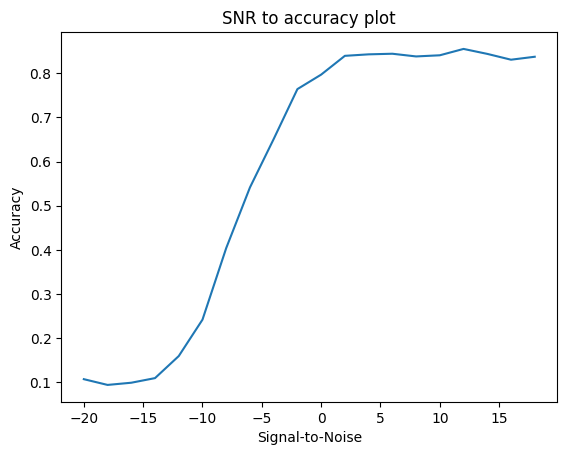

In [14]:
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

model_path = f"{model_name}_results/model_original"
model.save(model_path)

model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)

cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

2023-07-31 20:54:58.413291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-31 20:54:58.413326: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-31 20:54:58.413558: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml_results/model_original
2023-07-31 20:54:58.417411: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-31 20:54:58.417435: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml_results/model_original
2023-07-31 20:54:58.428698: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-31 20:54:58.529632: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_1d_v012_small_radio_ml_results/model_original
2023-07-31 20:54:58.552888: I tensorflow/

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.576590909090909}
8PSK test accuracy: 0.5602284527518172
AM-DSB test accuracy: 0.6800995024875622
AM-SSB test accuracy: 0.922740524781341
BPSK test accuracy: 0.6316042267050913
CPFSK test accuracy: 0.6130367304707708
GFSK test accuracy: 0.6587419514611194
PAM4 test accuracy: 0.6874051593323217
QAM16 test accuracy: 0.1892161757363954
QAM64 test accuracy: 0.6251881585549423
QPSK test accuracy: 0.5074320861096874
WBFM test accuracy: 0.26171875
Confusion matrix:
[[1079   15  586   54   22   31   21   16   55   43    4]
 [   3 1367  488   13    2   26    3    1    1    1  105]
 [   6   21 1899   50   12   38   13    3    4    4    8]
 [  16    5  629 1315    4   21   67    3    9   12    1]
 [  39   11  568   35 1185   46    8   10    9   16    6]
 [   6   24  541   28    8 1330    5    1    6    9   61]
 [   8   10  470   85    5   25 1359    2    7    4    2]
 [  98    9  374   56   22   19   15  379  983   48    0]
 [  75    7 

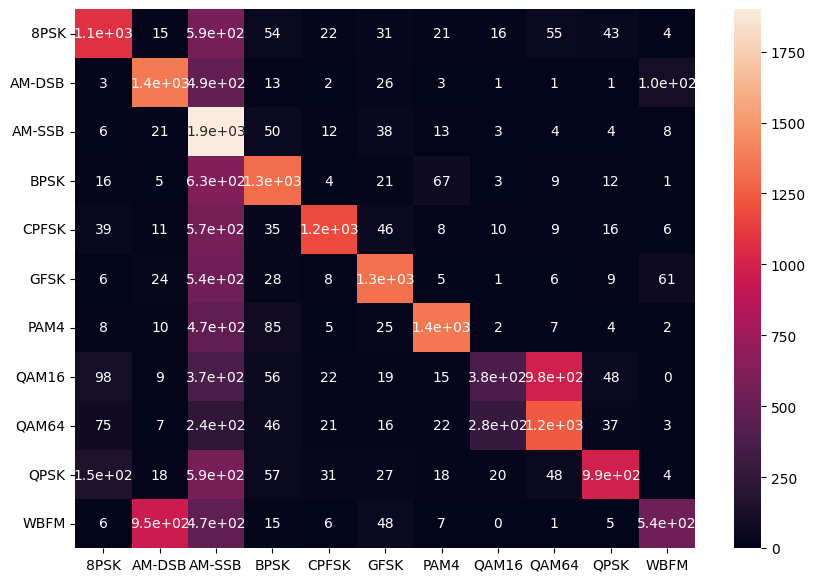

SNR: -20 -- Overall test accuracy: 0.10711150131694469
SNR: -18 -- Overall test accuracy: 0.09408602150537634
SNR: -16 -- Overall test accuracy: 0.09905660377358491
SNR: -14 -- Overall test accuracy: 0.10950226244343891
SNR: -12 -- Overall test accuracy: 0.15944700460829492
SNR: -10 -- Overall test accuracy: 0.24192059095106186
SNR: -8 -- Overall test accuracy: 0.4040492957746479
SNR: -6 -- Overall test accuracy: 0.5413184772516249
SNR: -4 -- Overall test accuracy: 0.6509769094138543
SNR: -2 -- Overall test accuracy: 0.7640845070422535
SNR: 0 -- Overall test accuracy: 0.796875
SNR: 2 -- Overall test accuracy: 0.8394160583941606
SNR: 4 -- Overall test accuracy: 0.8427906976744186
SNR: 6 -- Overall test accuracy: 0.8441674087266251
SNR: 8 -- Overall test accuracy: 0.8380603842634949
SNR: 10 -- Overall test accuracy: 0.8406593406593407
SNR: 12 -- Overall test accuracy: 0.855072463768116
SNR: 14 -- Overall test accuracy: 0.8438331854480923
SNR: 16 -- Overall test accuracy: 0.83065279091769

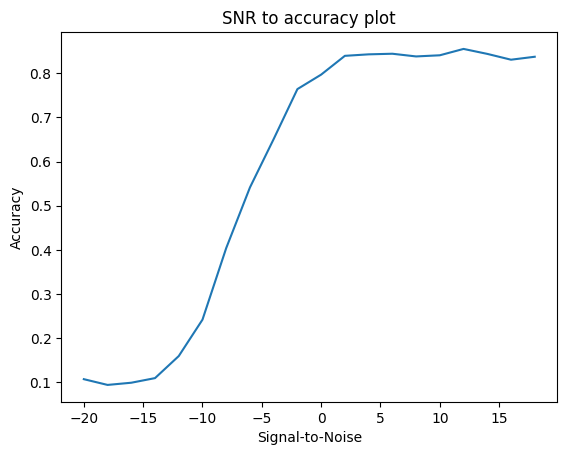

In [15]:
representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite)

In [16]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name,
    classes=radioml_ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


0it [00:00, ?it/s]

11it [00:00, 1542.02it/s]
